# Домашння работа
## Попытка обогнать numpy, не зная основ высокоэффективных вычислений

### Условия проведения
* система: Linux 6.12.47-gentoo-dist cpu:AMD Ryzen 7 6800HS ram:13.3Gb 
* numpy: 2.3.1 (Собран с флагами -march=native -mtune=native -O2 -flto -fsemantic-interposition)
* BLAS провайдер: Вероятно LAPAC, проверю позже
* Код противника писался на [xtensor](https://xtensor.readthedocs.io/en/latest/)(библиотека сохнаняющая почти все интерфейсы numpy)
* Частота процессора зафиксирована на 3.2Ггц
#### На данный моемент реализованы:
* [Ugaus](https://github.com/4eburxn/BbI4MaT/blob/87d7fc95e7547779274bcea0918a443854c3641c/lib/solver.hpp#L23-L46)  -- "обычный" Гаусс
* [Gaus](https://github.com/4eburxn/BbI4MaT/blob/87d7fc95e7547779274bcea0918a443854c3641c/lib/solver.hpp#L48-L82)  -- Гаусс с выбором главного элемента(по строкам)
* [LU](https://github.com/4eburxn/BbI4MaT/blob/87d7fc95e7547779274bcea0918a443854c3641c/lib/solver.hpp#L114-L155)  -- солвер на LU разложении
* [Oth](https://github.com/4eburxn/BbI4MaT/blob/6abe7597f1f4e60c8b62af03108c9996a306b5c3/lib/solver.hpp#L158-L194)  -- метод ортогонализации(плохие скорости, не участвует в сравнении, будет переделан позже)
* [Прогонки](https://github.com/4eburxn/BbI4MaT/blob/6abe7597f1f4e60c8b62af03108c9996a306b5c3/lib/solver.hpp#L196-L215)
* ##### Нормы:
  * [Вектора](https://github.com/4eburxn/BbI4MaT/blob/87d7fc95e7547779274bcea0918a443854c3641c/lib/norm.hpp#L9-L18)
  * [Матрицы](https://github.com/4eburxn/BbI4MaT/blob/87d7fc95e7547779274bcea0918a443854c3641c/lib/norm.hpp#L30-L40)
##### Другие участники:
* py  -- солвер numpy(BLAS под капотом)
* XT::BLAS -- солвер xtensor(BLAS под капотом)

#### Не готовы/сломаны/не придуман тест:
* [Метод простой итерации](https://github.com/4eburxn/BbI4MaT/blob/87d7fc95e7547779274bcea0918a443854c3641c/lib/itersolver.hpp#L16-L33) (не придуман тест)
* Якоби (сломан)
* Зейделя (сломан)
* Минимальных невязок (Не готов)
## Метод тестирования:
Запускается незамысловатый скрипт(tools/tester.sh). Этот скрипт выполняет цикл вида:
``` bash
for i in {1...1000}; do
    python gen_matrix.py "$i" > /tmp/matrix
    cat /tmp/matrix | ./xtensor_solver >> "test1000"
    cat /tmp/matrix | ./numpy_solver.py >> "test1000"
done
```
gen_matrix.py(tools/generator.py) с зафиксированным sid-ом генерирует матрицу и вектор для решения. Далее этот результат пишется в stdin бинарника xtensor и скрипта на питоне.
В файл test1000 записываются результаты тестирования(пример в папке tests).
### "Технологии"
При тесте использовался PGO(profile guided optimizations). Перед компиляцией итогового бинарника он "обучался" решая СЛАУ размером 1000 с ДРУГИМ sid. Это позволило выиграть около 1% для LU и около 3% для обоих Гауссов.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
Test_1000=dict()
types = ["Ugaus","Gaus","LU","py","XT::BLAS"]
for i in types:
    Test_1000[i]=([],[])
with open("tests/test10000_ntb") as f:
    for i in f.readlines():
        tmp = i.split()
        Test_1000[tmp[0]][0].append(int(tmp[1]))
        Test_1000[tmp[0]][1].append(float(tmp[2]))
for i in types:
    Test_1000[i]=(np.array(Test_1000[i][0]),np.array(Test_1000[i][1]))

# Время выполения 3<N<1000

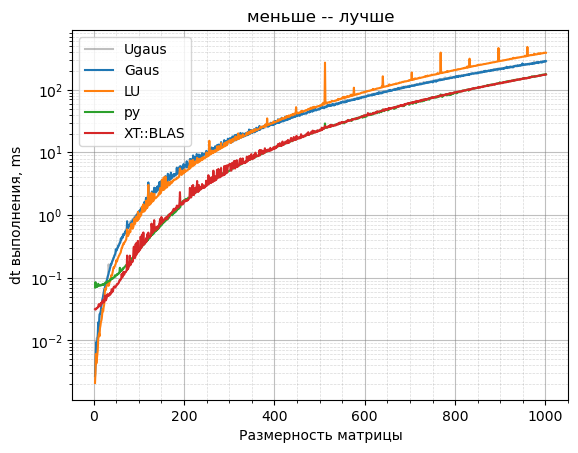

In [2]:
plt.plot(Test_1000["Ugaus"][0], Test_1000["Ugaus"][1],color='gray', alpha=0.5, label="Ugaus")
for i in types[1:]:
    plt.plot(Test_1000[i][0], Test_1000[i][1], label=i)
    
plt.grid(True, which='major', alpha=0.5, linewidth=0.8, color='gray')
plt.grid(True, which='minor', alpha=0.3, linestyle='--', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.xlabel("Размерность матрицы")
plt.ylabel("dt выполнения, ms")
plt.title("меньше -- лучше")
plt.yscale('log')
plt.legend()

# Отношение времени выполнения 3<N<1000.

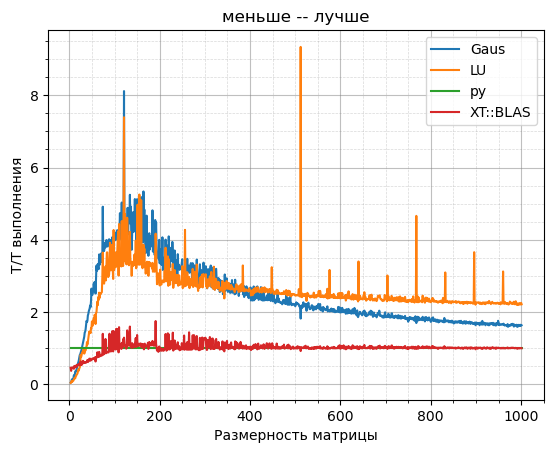

In [3]:
for i in types[1:]:
    plt.plot(Test_1000[i][0], Test_1000[i][1]/Test_1000["py"][1], label=i)
    
plt.grid(True, which='major', alpha=0.5, linewidth=0.8, color='gray')
plt.grid(True, which='minor', alpha=0.3, linestyle='--', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.xlabel("Размерность матрицы")
plt.ylabel("T/T выполнения")
plt.title("меньше -- лучше")
plt.legend()

# Тесты при N>1000 грязные(ноутбук был в использовании)! Хорошие тесты ТОЧНО появятся.

In [4]:

types = ["Ugaus","Gaus","LU","py","XT::BLAS"]
for i in types:
    Test_1000[i]=([],[])
with open("tests/test10000_true_ntb") as f:
    for i in f.readlines():
        tmp = i.split()
        Test_1000[tmp[0]][0].append(int(tmp[1]))
        Test_1000[tmp[0]][1].append(float(tmp[2]))
for i in types:
    Test_1000[i]=(np.array(Test_1000[i][0]),np.array(Test_1000[i][1]))

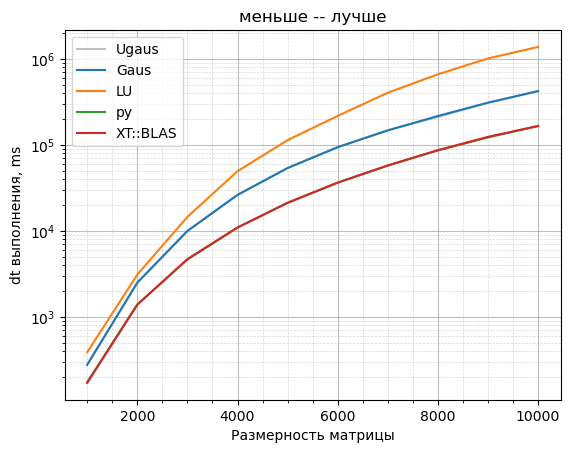

In [5]:
plt.plot(Test_1000["Ugaus"][0], Test_1000["Ugaus"][1],color='gray', alpha=0.5, label="Ugaus")
for i in types[1:]:
    plt.plot(Test_1000[i][0], Test_1000[i][1], label=i)
    
plt.grid(True, which='major', alpha=0.5, linewidth=0.8, color='gray')
plt.grid(True, which='minor', alpha=0.3, linestyle='--', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.xlabel("Размерность матрицы")
plt.ylabel("dt выполнения, ms")
plt.title("меньше -- лучше")
plt.yscale('log')
plt.legend()

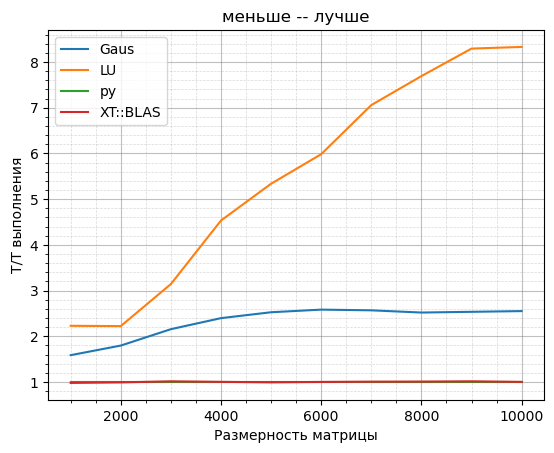

In [6]:
for i in types[1:]:
    plt.plot(Test_1000[i][0], Test_1000[i][1]/Test_1000["py"][1], label=i)
    
plt.grid(True, which='major', alpha=0.5, linewidth=0.8, color='gray')
plt.grid(True, which='minor', alpha=0.3, linestyle='--', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.xlabel("Размерность матрицы")
plt.ylabel("T/T выполнения")
plt.title("меньше -- лучше")
plt.legend()

## Метод прогонки
Способ тестирования отличается от прошлых, так как времени было мало. Сильно на результаты это влиять не должно

In [7]:

Test_thrd=([],[])
with open("tests/TestthriD") as f:
    for i in f.readlines():
        tmp = i.split()
        Test_thrd[0].append(int(tmp[1]))
        Test_thrd[1].append(float(tmp[2]))
Test_thrd=(np.array(Test_thrd[0]),np.array(Test_thrd[1]))

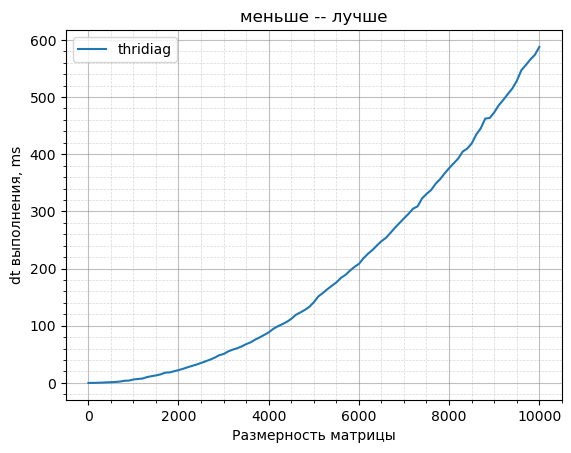

In [8]:
plt.plot(Test_thrd[0], Test_thrd[1], label="thridiag")
plt.grid(True, which='major', alpha=0.5, linewidth=0.8, color='gray')
plt.grid(True, which='minor', alpha=0.3, linestyle='--', linewidth=0.5, color='gray')
plt.minorticks_on()
plt.xlabel("Размерность матрицы")
plt.ylabel("dt выполнения, ms")
plt.title("меньше -- лучше")
plt.legend()


![Изображение](src/images.jpg)